In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline, interp1d
from scipy.spatial.distance import cdist
from scipy.stats import binned_statistic
from scipy.ndimage import gaussian_filter1d

def fit_3d_spine(pr_data: list[tuple[float, float, float, float, float]]) -> tuple[callable, callable, callable, callable]:
    """
    Fit 3D centreline and confidence evolution functions.
    
    Models: precision(threshold), recall(threshold), precision_width(threshold), recall_width(threshold)
    These capture how the PR curve moves through 3D space and how thick the confidence tube is.
    """
    data = np.array(pr_data)
    thresholds, precisions, recalls, p_widths, r_widths = data.T
    
    # Sort by threshold for spline fitting
    idx = np.argsort(thresholds)
    t, p, r, pw, rw = thresholds[idx], precisions[idx], recalls[idx], p_widths[idx], r_widths[idx]
    
    # Fit splines with extrapolation
    k = min(3, len(t) - 1) if len(t) > 1 else 1
    precision_spine = UnivariateSpline(t, p, k=k, s=0, ext=0)
    recall_spine = UnivariateSpline(t, r, k=k, s=0, ext=0)
    precision_width = interp1d(t, pw, kind='linear', fill_value='extrapolate')
    recall_width = interp1d(t, rw, kind='linear', fill_value='extrapolate')
    
    return precision_spine, recall_spine, precision_width, recall_width

def generate_3d_tube(pr_data: list[tuple[float, float, float, float, float]]) -> np.ndarray:
    """
    Generate complete 3D confidence tube via extrapolation in threshold space.
    
    Uses meshgrid vectorisation and scipy.spatial for distance-based extrapolation penalties.
    Single unified path handles both single and multi-point cases.
    """
    # Fit spine (handles single point as degenerate spline)
    p_spine, r_spine, p_width_func, r_width_func = fit_3d_spine(pr_data)
    
    # Threshold grid and data range
    t_grid = np.linspace(0, 1, 101)
    data_thresholds = np.array([d[0] for d in pr_data])
    
    # Compute extrapolation penalties using scipy.spatial
    t_distances = cdist(t_grid.reshape(-1, 1), data_thresholds.reshape(-1, 1), 'euclidean')
    extrapolation_penalty = np.min(t_distances, axis=1).flatten() * 0.35
    
    # Vectorised spine evaluation
    p_centres = p_spine(t_grid)
    r_centres = r_spine(t_grid)
    p_widths = p_width_func(t_grid) + extrapolation_penalty
    r_widths = r_width_func(t_grid) + extrapolation_penalty
    
    # Meshgrid for tube cross-sections: (threshold, precision_delta, recall_delta)
    t_mesh, dp_mesh, dr_mesh = np.meshgrid(t_grid, [-1, 1], [-1, 1], indexing='ij')
    
    # Broadcast operations for all tube points
    t_flat = t_mesh.flatten()
    p_centres_expanded = np.repeat(p_centres, 4)  # Each threshold gets 4 cross-section points
    r_centres_expanded = np.repeat(r_centres, 4)
    p_widths_expanded = np.repeat(p_widths, 4)
    r_widths_expanded = np.repeat(r_widths, 4)
    
    p_flat = p_centres_expanded + dp_mesh.flatten() * p_widths_expanded
    r_flat = r_centres_expanded + dr_mesh.flatten() * r_widths_expanded
    
    # Clamp to valid ranges
    p_flat = np.clip(p_flat, 0, 1)
    r_flat = np.clip(r_flat, 0, 1)
    
    return np.column_stack([t_flat, p_flat, r_flat])

def project_to_2d_envelope(tube_3d: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Project 3D tube to 2D precision-recall envelope.
    
    Uses scipy.stats.binned_statistic for vectorised min/max computation across recall bins.
    Operation: (threshold, precision, recall) -> (recall, precision) bounds.
    """
    # Extract 2D coordinates: recall=x, precision=y
    recalls = tube_3d[:, 2]
    precisions = tube_3d[:, 1]
    
    # Create recall bins
    r_bins = np.linspace(0, 1, 101)
    
    # Vectorised binning: find min/max precision in each recall bin
    p_upper, bin_edges, _ = binned_statistic(recalls, precisions, statistic='max', bins=r_bins)
    p_lower, _, _ = binned_statistic(recalls, precisions, statistic='min', bins=r_bins)
    
    # Handle empty bins with interpolation
    valid_mask = ~np.isnan(p_upper)
    if not np.all(valid_mask):
        bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2
        p_upper[~valid_mask] = np.interp(bin_centres[~valid_mask], bin_centres[valid_mask], p_upper[valid_mask])
        p_lower[~valid_mask] = np.interp(bin_centres[~valid_mask], bin_centres[valid_mask], p_lower[valid_mask])
    else:
        bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Light gaussian smoothing to remove projection artefacts
    p_upper = gaussian_filter1d(p_upper, sigma=1.0)
    p_lower = gaussian_filter1d(p_lower, sigma=1.0)
    
    # Enforce constraints
    p_upper = np.clip(p_upper, 0, 1)
    p_lower = np.clip(p_lower, 0, 1)
    p_lower = np.minimum(p_lower, p_upper)
    
    return bin_centres, p_upper, p_lower

def compute_pr_envelope_3d(pr_data: list[tuple[float, float, float, float, float]]) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Main function: 3D extrapolation approach to PR confidence envelopes.
    
    Pipeline:
    1. Fit 3D spine through (threshold, precision, recall) space
    2. Extrapolate confidence tube to full [0,1] threshold range  
    3. Project 3D tube to 2D PR envelope
    
    Superior to 2D methods: works in natural parameter space, principled extrapolation.
    """
    if not pr_data:
        return np.array([]), np.array([]), np.array([])
    
    # Generate 3D tube with extrapolation
    tube_3d = generate_3d_tube(pr_data)
    
    # Project to 2D envelope
    return project_to_2d_envelope(tube_3d)

def plot_pr_envelope_3d(pr_data: list[tuple[float, float, float, float, float]], 
                        title: str = "3D PR Envelope") -> None:
    """Plot 3D-derived confidence envelope with original data."""
    if not pr_data:
        return
    
    # Extract data
    thresholds, precisions, recalls, p_cis, r_cis = zip(*pr_data)
    
    # Compute envelope
    r_grid, p_upper, p_lower = compute_pr_envelope_3d(pr_data)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Confidence envelope
    ax.fill_between(r_grid, p_lower, p_upper, alpha=0.3, color='lightblue', label='3D Envelope')
    ax.plot(r_grid, p_upper, 'r-', linewidth=2, label='Upper Bound')
    ax.plot(r_grid, p_lower, 'r-', linewidth=2, label='Lower Bound')
    
    # Original data
    ax.errorbar(recalls, precisions, xerr=r_cis, yerr=p_cis,
               fmt='o', color='darkblue', markersize=6, capsize=4,
               markeredgecolor='white', markeredgewidth=1.5, label='Data ± CI')
    
    # Threshold labels
    for i, t in enumerate(thresholds):
        ax.annotate(f'{t:.2f}', (recalls[i], precisions[i]), 
                   xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)
    
    # Style
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Statistics
    area = np.trapz(p_upper - p_lower, r_grid)
    ax.text(0.02, 0.98, f'Area: {area:.3f}\nPoints: {len(pr_data)}\nMethod: 3D→2D',
           transform=ax.transAxes, va='top', fontsize=9,
           bbox=dict(boxstyle="round", facecolor="white", alpha=0.9))
    
    plt.tight_layout()
    plt.show()

# Main function for 3D PR confidence envelope computation

/tmp/ipykernel_3019606/4131880122.py:172: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(p_upper - p_lower, r_grid)


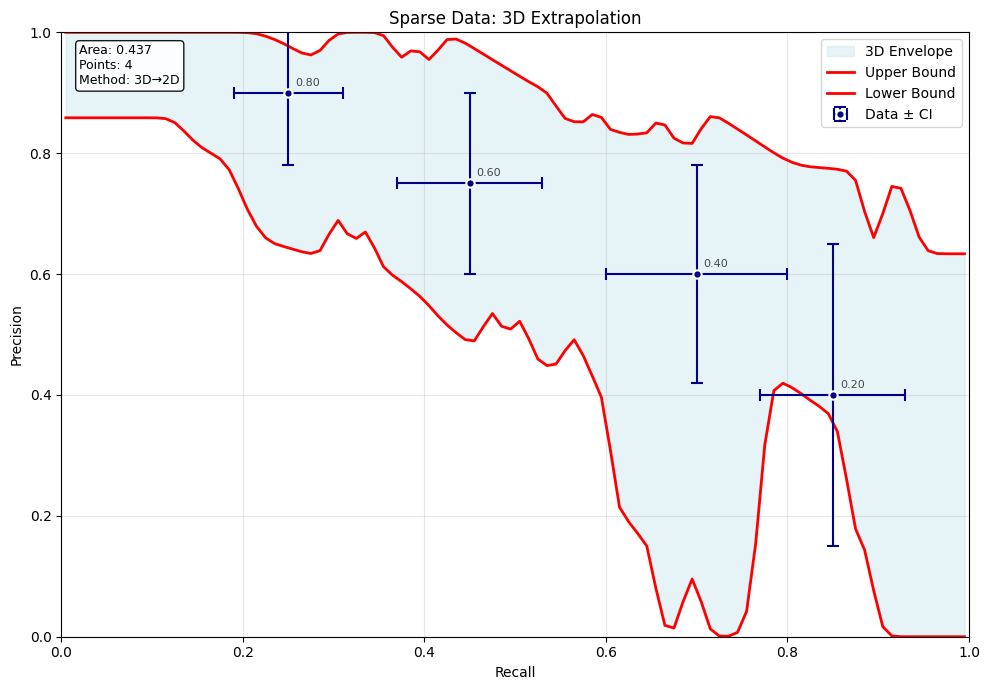

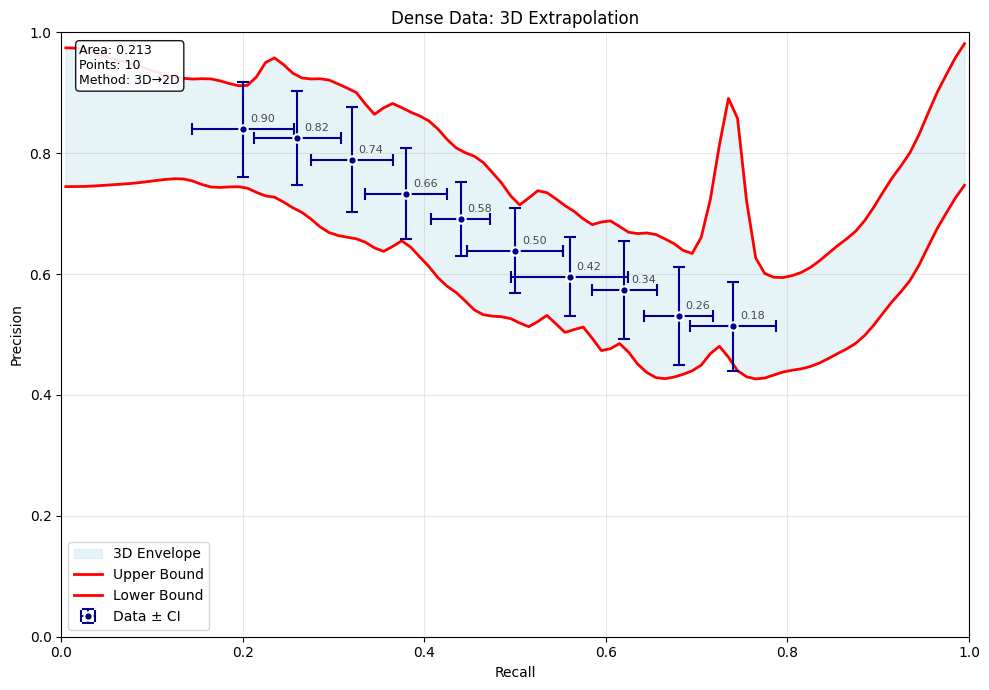

In [ ]:
# Single
single = [(0.5, 0.7, 0.4, 0.15, 0.1)]
plot_pr_envelope_3d(single, "Single Point: 3D Extrapolation")

# Sparse data test
sparse = [
    (0.9, 0.95, 0.15, 0.08, 0.05),  # High threshold: high precision, low recall
    (0.7, 0.85, 0.35, 0.10, 0.08),  # Medium-high threshold  
    (0.5, 0.70, 0.60, 0.12, 0.10),  # Medium threshold: balanced
    (0.3, 0.55, 0.80, 0.15, 0.08),  # Low threshold: lower precision, high recall
    (0.1, 0.40, 0.90, 0.20, 0.06),  # Very low threshold: low precision, very high recall
]
plot_pr_envelope_3d(sparse, "Sparse Data: 3D Extrapolation")

# Dense data test
np.random.seed(42)
dense = []
for i in range(10):
    t = 0.9 - i * 0.08
    r = 0.2 + i * 0.06
    p = 0.95 - 0.6 * r + np.random.normal(0, 0.02)
    p = np.clip(p, 0.1, 0.9)
    p_ci = np.clip(0.08 + np.random.normal(0, 0.01), 0.03, 0.12)
    r_ci = np.clip(0.05 + np.random.normal(0, 0.01), 0.02, 0.08)
    dense.append((t, p, r, p_ci, r_ci))

plot_pr_envelope_3d(dense, "Dense Data: 3D Extrapolation")